In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import norm, rankdata
import warnings
import gc
import os
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

plt.style.use('seaborn')
sns.set(font_scale=1)
pd.set_option('display.max_columns', 500)

In [2]:
path = '../input'
test = pd.read_csv(path + '/Metro_testA/testA_submit_2019-01-29.csv')
test_28 = pd.read_csv(path + '/Metro_testA/testA_record_2019-01-28.csv')

#### **1、构造基本特征，主要为时间特征、count、sum等。**

In [3]:
def get_base_features(df_):
    
    df = df_.copy()
    # base time
    df['day'] = df['time'].apply(lambda x: int(x[8:10]))
    df['week'] = pd.to_datetime(df['time']).dt.dayofweek + 1
    df['weekend'] = (pd.to_datetime(df.time).dt.weekday >=5).astype(int)
    df['hour'] = df['time'].apply(lambda x: int(x[11:13]))
    df['minute'] = df['time'].apply(lambda x: int(x[14:15]+'0'))
    
    # count,sum
    result = df.groupby(['stationID', 'week', 'weekend', 'day', 'hour', 'minute']).status.agg(['count', 'sum']).reset_index()            
     
    # nunique
    tmp = df.groupby(['stationID'])['deviceID'].nunique().reset_index(name='nuni_deviceID_of_stationID')
    result = result.merge(tmp, on=['stationID'], how='left')
    tmp = df.groupby(['stationID','hour'])['deviceID'].nunique().reset_index(name='nuni_deviceID_of_stationID_hour')
    result = result.merge(tmp, on=['stationID','hour'], how='left')
    tmp = df.groupby(['stationID','hour','minute'])['deviceID'].nunique().\
                                           reset_index(name='nuni_deviceID_of_stationID_hour_minute')
    result  = result.merge(tmp, on=['stationID','hour','minute'], how='left')
    
    # in,out
    result['inNums']  = result['sum']
    result['outNums'] = result['count'] - result['sum']
    
    #
    result['day_since_first'] = result['day'] - 1 
#     result.fillna(0, inplace=True)
    del result['sum'],result['count']
    
    return result


In [4]:
data = get_base_features(test_28)

#### **2、加载所有文件数据**

In [5]:
data_list = os.listdir(path+'/Metro_train/')
for i in range(0, len(data_list)):
    if data_list[i].split('.')[-1] == 'csv':
        print(data_list[i], i)
        df = pd.read_csv(path+'/Metro_train/' + data_list[i])
        df = get_base_features(df)
        data = pd.concat([data, df], axis=0, ignore_index=True)
    else:
        continue

record_2019-01-01.csv 0
record_2019-01-02.csv 1
record_2019-01-03.csv 2
record_2019-01-04.csv 3
record_2019-01-05.csv 4
record_2019-01-06.csv 5
record_2019-01-07.csv 6
record_2019-01-08.csv 7
record_2019-01-09.csv 8
record_2019-01-10.csv 9
record_2019-01-11.csv 10
record_2019-01-12.csv 11
record_2019-01-13.csv 12
record_2019-01-14.csv 13
record_2019-01-15.csv 14
record_2019-01-16.csv 15
record_2019-01-17.csv 16
record_2019-01-18.csv 17
record_2019-01-19.csv 18
record_2019-01-20.csv 19
record_2019-01-21.csv 20
record_2019-01-22.csv 21
record_2019-01-23.csv 22
record_2019-01-24.csv 23
record_2019-01-25.csv 24


#### **3、由于26和27号数据不存在，故剔除所有周末的数据。**

In [6]:
# 剔除周末,并修改为连续时间
data = data[(data.day!=5)&(data.day!=6)]
data = data[(data.day!=12)&(data.day!=13)]
data = data[(data.day!=19)&(data.day!=20)]
data = data[(data.day!=26)&(data.day!=27)]

def fix_day(d):
    if d in [1,2,3,4]:
        return d
    elif d in [7,8,9,10,11]:
        return d - 2
    elif d in [14,15,16,17,18]:
        return d - 4
    elif d in [21,22,23,24,25]:
        return d - 6
    elif d in [28]:
        return d - 8
data['day'] = data['day'].apply(fix_day)

In [7]:
data.head()

,stationID,week,weekend,day,hour,minute,nuni_deviceID_of_stationID,nuni_deviceID_of_stationID_hour,nuni_deviceID_of_stationID_hour_minute,inNums,outNums,day_since_first
0,0,1,0,20,0,0,18,3,1,0,1,27
1,0,1,0,20,0,10,18,3,2,0,2,27
2,0,1,0,20,4,30,18,1,1,0,1,27
3,0,1,0,20,5,30,18,11,5,22,0,27
4,0,1,0,20,5,40,18,11,7,14,0,27


#### **4、拼接测试集数据**

In [8]:
test['week'] = pd.to_datetime(test['startTime']).dt.dayofweek + 1
test['weekend'] = (pd.to_datetime(test.startTime).dt.weekday >=5).astype(int)
test['day'] = test['startTime'].apply(lambda x: int(x[8:10]))
test['hour'] = test['startTime'].apply(lambda x: int(x[11:13]))
test['minute'] = test['startTime'].apply(lambda x: int(x[14:15]+'0'))
test['day_since_first'] = test['day'] - 1
test = test.drop(['startTime','endTime'], axis=1)
data = pd.concat([data,test], axis=0, ignore_index=True)

stat_columns = ['inNums','outNums']

#### **5、提取前一天数据作为特征**

In [9]:
def get_refer_day(d):
    if d == 20:
        return 29
    else:
        return d + 1

tmp = data.copy()
tmp_df = tmp[tmp.day==1]
tmp_df['day'] = tmp_df['day'] - 1
tmp = pd.concat([tmp, tmp_df], axis=0, ignore_index=True)
tmp['day'] = tmp['day'].apply(get_refer_day)

for f in stat_columns:
    tmp.rename(columns={f: f+'_last'}, inplace=True) 
    
tmp = tmp[['stationID','day','hour','minute','inNums_last','outNums_last']]

data = data.merge(tmp, on=['stationID','day','hour','minute'], how='left')
data.fillna(0, inplace=True)

#### **6、按week,hour,minute分别对inNums和outNums构造统计特征**

In [10]:
tmp = data.groupby(['stationID','week','hour','minute'], as_index=False)['inNums'].agg({
                                                                        'inNums_whm_max':'max',
                                                                        'inNums_whm_min'    : 'min',
                                                                        'inNums_whm_mean'   : 'mean'
                                                                        })
data = data.merge(tmp, on=['stationID','week','hour','minute'], how='left')

tmp = data.groupby(['stationID','week','hour','minute'], as_index=False)['outNums'].agg({
                                                                        'outNums_whm_max'    : 'max',
                                                                        'outNums_whm_min'    : 'min',
                                                                        'outNums_whm_mean'   : 'mean'
                                                                        })
data = data.merge(tmp, on=['stationID','week','hour','minute'], how='left')

tmp = data.groupby(['stationID','week','hour'], as_index=False)['inNums'].agg({
                                                                        'inNums_wh_max'    : 'max',
                                                                        'inNums_wh_min'    : 'min',
                                                                        'inNums_wh_mean'   : 'mean'
                                                                        })
data = data.merge(tmp, on=['stationID','week','hour'], how='left')

tmp = data.groupby(['stationID','week','hour'], as_index=False)['outNums'].agg({
                                                                        #'outNums_wh_max'    : 'max',
                                                                        #'outNums_wh_min'    : 'min',
                                                                        'outNums_wh_mean'   : 'mean'
                                                                        })
data = data.merge(tmp, on=['stationID','week','hour'], how='left')

#### **7、恢复初始时间**

In [11]:
def recover_day(d):
    if d in [1,2,3,4]:
        return d
    elif d in [5,6,7,8,9]:
        return d + 2
    elif d in [10,11,12,13,14]:
        return d + 4
    elif d in [15,16,17,18,19]:
        return d + 6
    elif d == 20:
        return d + 8
    else:
        return d

all_columns = [f for f in data.columns if f not in ['weekend','inNums','outNums']]
### all data
all_data = data[data.day!=29]
all_data['day'] = all_data['day'].apply(recover_day)
X_data = all_data[all_columns].values

train = data[data.day <20]
train['day'] = train['day'].apply(recover_day)
X_train = train[all_columns].values

valid = data[data.day==20]
valid['day'] = valid['day'].apply(recover_day)
X_valid = valid[all_columns].values

test  = data[data.day==29]
X_test = test[all_columns].values

#### **8、构建训练模型**

In [12]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 63,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.9,
    'bagging_seed':0,
    'bagging_freq': 1,
    'verbose': 1,
    'reg_alpha':2,
    'reg_lambda':5
}

######################################################inNums
y_train = train['inNums']
y_valid = valid['inNums']
y_data  = all_data['inNums']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )

### all_data
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )
test['inNums'] = gbm.predict(X_test)

######################################################outNums
y_train = train['outNums']
y_valid = valid['outNums']
y_data  = all_data['outNums']
lgb_train = lgb.Dataset(X_train, y_train)
lgb_evals = lgb.Dataset(X_valid, y_valid , reference=lgb_train)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000,
                valid_sets=[lgb_train,lgb_evals],
                valid_names=['train','valid'],
                early_stopping_rounds=200,
                verbose_eval=1000,
                )

### all_data
lgb_train = lgb.Dataset(X_data, y_data)
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=gbm.best_iteration,
                valid_sets=[lgb_train],
                valid_names=['train'],
                verbose_eval=1000,
                )
test['outNums'] = gbm.predict(X_test)

sub = pd.read_csv(path + '/Metro_testA/testA_submit_2019-01-29.csv')
sub['inNums']   = test['inNums'].values
sub['outNums']  = test['outNums'].values
# 结果修正
sub.loc[sub.inNums<0 , 'inNums']  = 0
sub.loc[sub.outNums<0, 'outNums'] = 0
sub[['stationID', 'startTime', 'endTime', 'inNums', 'outNums']].to_csv('../output/sub_032313.csv', index=False)

Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 12.0682	valid's l1: 14.5228
[2000]	train's l1: 10.7951	valid's l1: 13.7258
[3000]	train's l1: 10.4471	valid's l1: 13.4897
[4000]	train's l1: 10.1911	valid's l1: 13.386
[5000]	train's l1: 9.97677	valid's l1: 13.3315
[6000]	train's l1: 9.79364	valid's l1: 13.2639
[7000]	train's l1: 9.63208	valid's l1: 13.2099
[8000]	train's l1: 9.49291	valid's l1: 13.184
Early stopping, best iteration is:
[8075]	train's l1: 9.483	valid's l1: 13.181
[1000]	train's l1: 12.1914
[2000]	train's l1: 10.9096
[3000]	train's l1: 10.5511
[4000]	train's l1: 10.2904
[5000]	train's l1: 10.0797
[6000]	train's l1: 9.89379
[7000]	train's l1: 9.73729
[8000]	train's l1: 9.59475
Training until validation scores don't improve for 200 rounds.
[1000]	train's l1: 13.4185	valid's l1: 16.64
[2000]	train's l1: 12.2057	valid's l1: 15.6221
[3000]	train's l1: 11.8644	valid's l1: 15.47
[4000]	train's l1: 11.6024	valid's l1: 15.3327
[5000]	train's l1: 11

In [13]:
features = all_columns
feat_import = pd.DataFrame()
feat_import["feature"] = features
feat_import["importance"] = gbm.feature_importance()

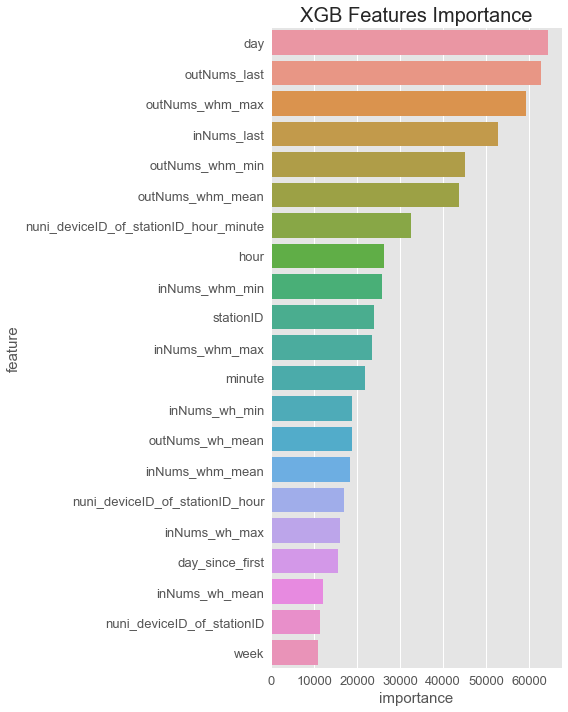

In [15]:
# 画出特征重要性图
plt.style.use('ggplot')
cols = (feat_import[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:].index)

best_features = feat_import.loc[feat_import.feature.isin(cols)]
plt.figure(figsize=(8,10))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance", ascending=False))
plt.title('XGB Features Importance', fontsize=20)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("importance", fontsize=15)
plt.ylabel("feature", fontsize=15)
plt.tight_layout()
# plt.savefig("../fig_out/xgb_importances_didi_"+datestr+".png")
plt.show()